In this notebook trys the following approachs:

- Used pretrained model to embed ingredients into a high dimensional vector space
- Trained Random Forest, xgboost, Support Vectos Classifier with rbf kernel
- Applied pca on the data set to reduce the features

The best performed model is `SVC` with C=10, which has validation accuracy of 0.775

In [101]:
# Import packages
import re
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.metrics import accuracy_score

import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# load the data
file_train = open("data/train.json", "r")
file_test = open("data/test.json", "r")
data_train = json.load(file_train)
data_test = json.load(file_test)

In [103]:
# make labels for training set
y_train = [recipe['cuisine'] for recipe in data_train]
y_train = pd.DataFrame(y_train, columns=['cuisine'])
y_train.head()

,cuisine
0,greek
1,southern_us
2,filipino
3,indian
4,indian


In [104]:
# Transform the labels into numerical values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train.cuisine.astype(str))
y_train['cusine_code'] = label_encoder.transform(y_train.cuisine.astype(str)).astype(int)



In [105]:
y_train.head()

,cuisine,cusine_code
0,greek,6
1,southern_us,16
2,filipino,4
3,indian,7
4,indian,7


In [106]:
# train test split with random_state=330, this will be used later 
data_tt, data_val, y_tt, y_val = train_test_split(data_train,y_train,
                                                  test_size = .2,
                                                 shuffle=True,
                                                  random_state=330,
                                                 stratify=y_train['cusine_code'])

In [107]:
# load the word to vec model
import gensim.downloader as api
w2v_model = api.load("glove-wiki-gigaword-200")

In [108]:
# Creating the embedding vectors for data_train

embedding_dim = len(w2v_model.get_vector('hello'))
Data = np.zeros((len(data_train), embedding_dim))

for row in range(len(data_train)):
    ingredients = data_train[row]['ingredients']
    ingred_list = []
    for ingred in ingredients:
        ingred = ingred.lower()
        res = re.split('[^a-zA-Z0-9]+', ingred) 
        ingred_list.extend(res)
    
    Data[row] = w2v_model.get_mean_vector(ingred_list)
X_train = pd.DataFrame(Data)

In [109]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.002627,-0.036597,0.027758,0.073192,0.037606,-0.000273,-0.028357,0.001554,0.012220,-0.009157,...,0.038666,-0.014899,-0.052571,-0.056018,-0.018443,-0.009591,-0.006813,0.003290,-0.043386,-0.015126
1,0.001799,-0.028751,-0.002969,0.055429,-0.008976,-0.015959,-0.053601,-0.033294,0.016055,-0.007597,...,0.019943,-0.005595,-0.028199,-0.032006,0.009229,0.027900,-0.026922,-0.010154,-0.061595,0.001218
2,-0.027392,-0.004322,0.011955,0.028473,-0.007071,-0.013566,-0.065648,-0.010772,-0.037471,-0.005291,...,0.009980,0.008733,-0.048624,-0.040644,-0.023413,0.042839,-0.026934,-0.005705,-0.092200,0.009834
3,0.002071,0.024312,0.012501,0.053314,-0.014000,0.016841,-0.078699,-0.018861,0.002302,-0.089351,...,0.015554,-0.014402,-0.048068,0.019755,0.014529,0.045151,-0.042506,-0.001403,-0.048805,0.000392
4,-0.021370,-0.009524,-0.000628,0.043568,-0.001422,-0.015975,-0.048983,-0.006506,-0.023861,-0.038026,...,-0.004160,-0.016225,-0.041723,-0.041368,-0.022773,0.043168,-0.029039,-0.037174,-0.068200,-0.002920


In [110]:
X_train.shape

(39774, 200)

In [111]:
# we use the same train_test_split with random_state=330
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, 
                                           test_size=0.2,
                                            shuffle=True,
                                           random_state=330,
                                           stratify=y_train['cusine_code'])

In [112]:
# random forest classifier with default parameters
rf = RandomForestClassifier()

rf.fit(X_tt.values, y_tt['cusine_code'])
rf_y_val_pred = rf.predict(X_val.values)

In [113]:
accuracy_score(y_val['cusine_code'], rf_y_val_pred)

0.6504085480829667

In [114]:
# xgboost with default parameters
xgb = xgboost.XGBClassifier()
xgb.fit(X_tt.values, y_tt['cusine_code'])

xgb_y_val_pred = xgb.predict(X_val.values)
accuracy_score(y_val['cusine_code'], xgb_y_val_pred)

0.7236957888120679

In [99]:
# svc with rbf kernel
svc = SVC(C=10, kernel = 'rbf')
svc.fit(X_tt, y_tt['cusine_code'])
svc_y_val_pred = svc.predict(X_val)
accuracy_score(y_val['cusine_code'], svc_y_val_pred)

0.7632935260842237

#### Now we apply PCA on the data before training model

In [73]:
# PCA
pca = PCA(0.99)
pca.fit(X_train.values)

X_train_pca = pca.transform(X_train.values)
X_train_pca.shape

(39774, 141)

In [74]:
# same train test split after pca
X_tt_pca, X_val_pca, y_tt, y_val = train_test_split(X_train_pca, y_train, 
                                           test_size=0.2,
                                            shuffle=True,
                                           random_state=330,
                                           stratify=y_train['cusine_code'])

In [76]:
# xgboost after pca
xgb = xgboost.XGBClassifier()
xgb.fit(X_tt_pca, y_tt['cusine_code'])
xgb_y_val_pred_pca = xgb.predict(X_val_pca)
accuracy_score(y_val['cusine_code'], xgb_y_val_pred_pca)


0.7226901319924576

In [97]:
# support vector classifier with rbf kernel
svc = SVC(C=1, kernel = 'rbf')
svc.fit(X_tt_pca, y_tt['cusine_code'])
svc_y_val_pred_pca = svc.predict(X_val_pca)
accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca)

0.7630421118793211

In [82]:
# Hyperparameter tuning for C
C_list = [0.01, 0.1, 10, 100]
for C in C_list:
    svc = SVC(C=C, kernel = 'rbf')
    svc.fit(X_tt_pca, y_tt['cusine_code'])
    svc_y_val_pred_pca = svc.predict(X_val_pca)
    print("Accuracy for " + str(C) + 'is: ', accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca))

Accuracy for 0.01is:  0.4979258328095537
Accuracy for 0.1is:  0.6566939032055311
Accuracy for 10is:  0.7749842866121935
Accuracy for 100is:  0.7675675675675676


In [85]:
# a refined tuning
C_list = [5, 20, 40, 60]
for C in C_list:
    svc = SVC(C=C, kernel = 'rbf')
    svc.fit(X_tt_pca, y_tt['cusine_code'])
    svc_y_val_pred_pca = svc.predict(X_val_pca)
    print("Accuracy for " + str(C) + ' is: ', accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca))

Accuracy for 5 is:  0.7739786297925833
Accuracy for 20 is:  0.7702074167190446
Accuracy for 40 is:  0.7679446888749214
Accuracy for 60 is:  0.7676932746700189


In [86]:
# we use C=10 as the final choice
svc = SVC(C=10, kernel = 'rbf')
svc.fit(X_tt_pca, y_tt['cusine_code'])
svc_y_val_pred_pca = svc.predict(X_val_pca)
print("validation accuracy is: ", accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca))

validation accuracy is:  0.7749842866121935


In [90]:
# a two dimensional visualization of the training data
reducer = umap.UMAP()
reducer.fit(X_tt_pca)
embedding = reducer.transform(X_tt_pca)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


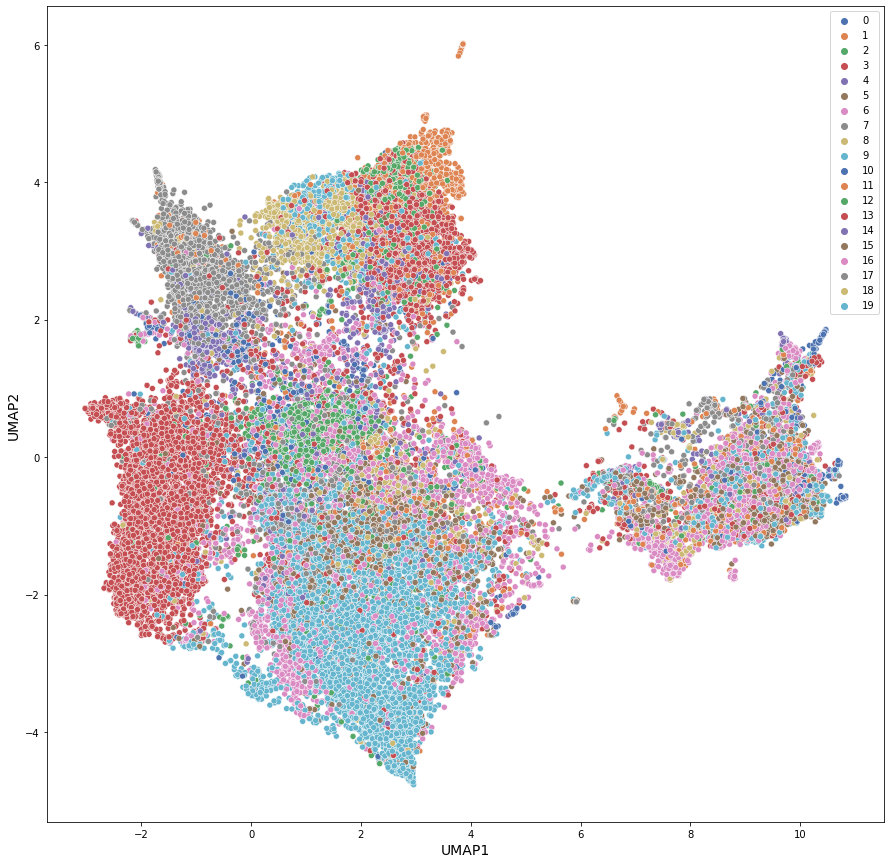

In [95]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1],
               hue = y_tt['cusine_code'],
               palette = 'deep')
plt.xlabel('UMAP1', fontsize=14)
plt.ylabel('UMAP2', fontsize=14)
plt.legend()
plt.show()